In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# MNIST

import repos.pyjunk.junktools as junktools
from repos.pyjunk.junktools import utils
import numpy as np

mnist_train_x, mnist_test_x, mnist_train_y, mnist_test_y = utils.load_mnist(include_labels=True)
print(mnist_train_x.shape)
print(mnist_train_y.shape)

min_class = np.min(mnist_train_y)
max_class = np.max(mnist_train_y)
n_classes = (max_class - min_class) + 1

print("Min class: %d max class: %d, total classes: %d" % (min_class, max_class, n_classes))

(60000, 28, 28, 1)
(60000,)
Min class: 0 max class: 9, total classes: 10


(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


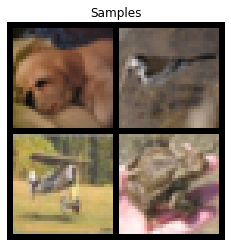

In [25]:
# CIFAR-10

import repos.pyjunk.junktools as junktools
from repos.pyjunk.junktools import utils
import numpy as np


cifar_train_x, cifar_train_y, cifar_test_x, cifar_test_y = utils.load_cifar(include_labels=True)
print(cifar_train_x.shape)
print(cifar_train_y.shape)
print(cifar_test_x.shape)
print(cifar_test_y.shape)

n_row = 2
utils.visualize_data(cifar_train_x, size=n_row ** 2 , nrow=n_row)

# min_class = np.min(cifar_train_y)
# max_class = np.max(cifar_train_y)
# n_classes = (max_class - min_class) + 1
# print("Min class: %d max class: %d, total classes: %d" % (min_class, max_class, n_classes))

In [4]:
from repos.pyjunk.models.GAN.WGAN_GP import WGAN_GP
from repos.pyjunk.solvers.SGANTorchSolver import SGANTorchSolver

import repos.pyjunk.junktools.pytorch_utils as ptu
ptu.SetGPUMode(True)

B, H, W, C = cifar_train_x.shape
input_shape = (H, W, C)
input_dim = H * W * C

ganModel = WGAN_GP(
    input_shape = input_shape,
    n_filters = 128
)

# Set up the solver
dictSolverParams = {
    'lr': 2e-4,
    'epochs': 500,
    'strOptimizer': 'Adam',
    'batch_size': 128,
    'n_critic': 5,
    'betas': (0.0, 0.9),
    'checkpoint_file_name': 'wgap-gp-baseline_checkpoint.tar',
    'checkpoint_epochs': 10
    
}

# test gen, disc
test_data, z_data = ganModel.generator.sample(10)
print(test_data.shape)
pred_fake = ganModel.discriminator(test_data)
print(pred_fake.shape)

solver = SGANTorchSolver(ganModel, dictSolverParams)
solver.train_gan_epochs(cifar_train_x, fVerbose=False)

torch.Size([10, 3, 32, 32])
torch.Size([10, 1])


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
import torch

strCheckpoint = 'wgap-gp-baseline_checkpoint.tar'

solver.SaveCheckpoint(strCheckpoint, 1)

In [5]:
import torch

strCheckpoint = 'wgap-gp-baseline_checkpoint.tar'

solver.LoadCheckpoint(strCheckpoint)
#solver.train_gan_epochs(cifar_train_x, fVerbose=False)

450

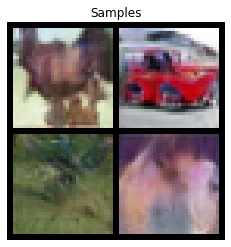

In [26]:
from repos.pyjunk.junktools.image import image
from repos.pyjunk.junktools import utils
import numpy as np

n_row = 2
samples = ganModel.sample(n_row ** 2).cpu().numpy()
utils.visualize_data(samples, size=n_row ** 2, nrow=n_row,)
# for sample in samples:
#     newImage = image(tor  
#     newImage.visualize()

# #print(list(ganModel.generator.parameters()))
# print(list(ganModel.discriminator.parameters()))

## Windridge Dataset

Loading frames 1 to 3482


frame:   0%|          | 0/3481 [00:00<?, ?it/s]

Frameset: wr_210518_32, 3481 frames with 12 channels JIT enabled
(3481, 32, 32, 28)
Frameset: wr_210518RGB, 3481 frames with 1 channels JIT enabled
(3481, 32, 32, 3)
(2784, 32, 32, 3)
(697, 32, 32, 3)


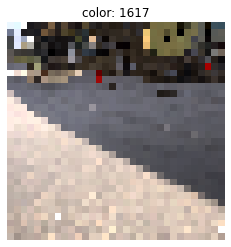

In [1]:
%load_ext autoreload
%autoreload 2

# load new frame-set

from repos.pyjunk.junktools.frameset import frameset

frameset_res = 32
#strNewFramesetName = 'primitives_64_wht'
strFramesetBaseName = 'wr_210518'
strFramesetName = strFramesetBaseName + '_' + str(frameset_res)
img_size = 32
batch_size = 128
test_batch_size = 128
#num_frames = 4900
#num_frames = 100
num_frames = None

orig_frameset = frameset(strFramesetName, num_frames=num_frames, fJITLoading=True, fVerbose=False)
orig_frameset.Print()
print(orig_frameset.shape())

# Split up into Conditional and RGB Target framesets
framesetRGB = frameset(
    sourceFrameset=orig_frameset, 
    strNewFramesetName=strFramesetBaseName + "RGB", 
    sourceChannels=['Color']
)

framesetRGB.Print()
#framesetRGB[0].visualize()

# #spheresCond.visualize()
# #framesetRGB.visualize()

# Shape of a single frame
print(framesetRGB.shape())

# split spheresRGB into spheresRGB_train, speheresRGB_test

framesetRGB_train, framesetRGB_test = framesetRGB.split_into_train_and_test(0.8)
print(framesetRGB_train.shape())
print(framesetRGB_test.shape())

framesetRGB_train[0].visualize()

In [2]:
from repos.pyjunk.models.GAN.WGAN_GP import WGAN_GP
from repos.pyjunk.solvers.SGANTorchSolver import SGANTorchSolver

import repos.pyjunk.junktools.pytorch_utils as ptu
#ptu.SetGPUMode(True)

B, H, W, C = framesetRGB_train.shape()
input_shape = (H, W, C)
input_dim = H * W * C

ganModel = WGAN_GP(
    input_shape = input_shape,
    n_filters = 128
)

# Set up the solver
dictSolverParams = {
    'lr': 2e-4,
    'epochs': 500,
    'strOptimizer': 'Adam',
    'batch_size': 128,
    'n_critic': 5,
    'betas': (0.0, 0.9),
    'checkpoint_file_name': 'wgap-gp-wr_checkpoint.tar',
    'checkpoint_epochs': 10
    
}

# test gen, disc
test_data, z_data = ganModel.generator.sample(10)
print(test_data.shape)
pred_fake = ganModel.discriminator(test_data)
print(pred_fake.shape)

solver = SGANTorchSolver(ganModel, dictSolverParams)
#solver.train_gan_epochs_frameset(framesetRGB_train, fVerbose=False)

torch.Size([10, 3, 32, 32])
torch.Size([10, 1])


In [18]:
import torch

strCheckpoint = 'wgap-gp-wr_checkpoint.tar'

solver.SaveCheckpoint(strCheckpoint, 1)

In [19]:
import torch

strCheckpoint = 'wgap-gp-wr_checkpoint.tar'

solver.LoadCheckpoint(strCheckpoint)
solver.train_gan_epochs_frameset(framesetRGB_train, fVerbose=False)

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/2784 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/2784 [00:00<?, ?it/s]

KeyboardInterrupt: 

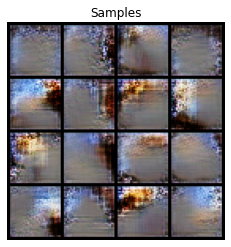

In [20]:
from repos.pyjunk.junktools.image import image
from repos.pyjunk.junktools import utils
import numpy as np

n_row = 4
samples = ganModel.sample(n_row ** 2).cpu().numpy()
utils.visualize_data(samples, size=n_row ** 2, nrow=n_row,)
# for sample in samples:
#     newImage = image(tor  
#     newImage.visualize()

# #print(list(ganModel.generator.parameters()))
# print(list(ganModel.discriminator.parameters()))